In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../implementations")) 
from ekf import ExtendedKalmanFilter

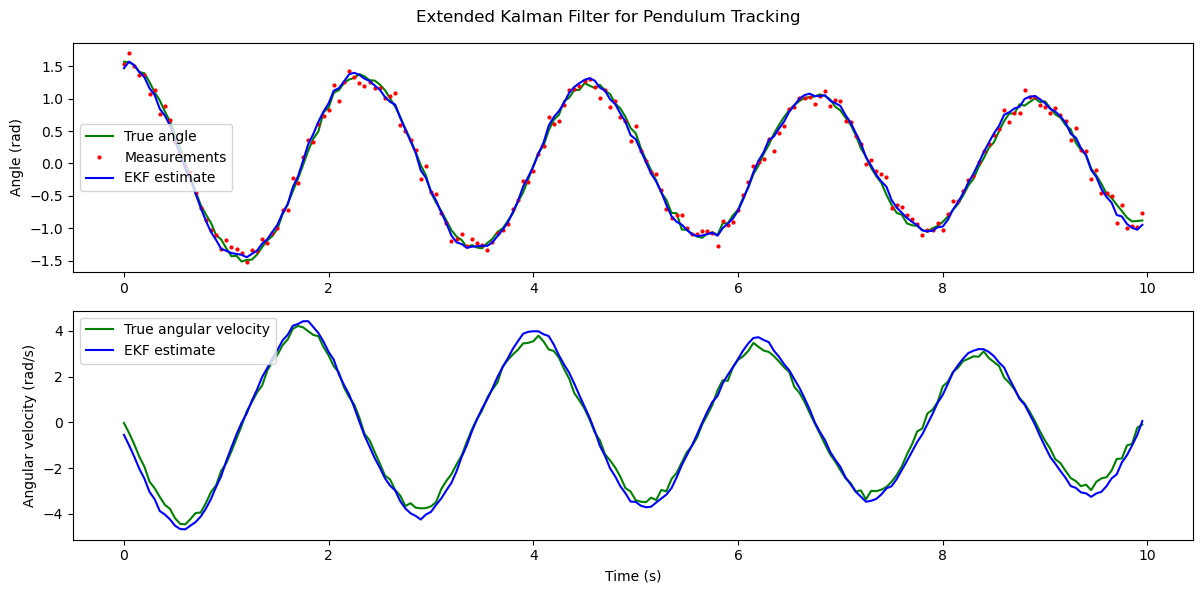

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Pendulum parameters
g = 9.81  # gravity (m/s^2)
L = 1.0    # length of pendulum (m)
b = 0.1    # damping coefficient

# True pendulum dynamics (nonlinear)
def pendulum_dynamics(x, t):
    theta, theta_dot = x
    dtheta_dt = theta_dot
    dtheta_dot_dt = -(g/L)*np.sin(theta) - b*theta_dot
    return [dtheta_dt, dtheta_dot_dt]

# Simulation parameters
dt = 0.05  # time step
t = np.arange(0, 10, dt)  # time vector

# Initial conditions: [angle (rad), angular velocity (rad/s)]
x0 = [np.pi/2, 0]

# Simulate true pendulum motion
true_states = odeint(pendulum_dynamics, x0, t)

# Add process noise to simulate real system
process_noise = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=np.diag([0.001, 0.01]), 
    size=len(t)
)
true_states += process_noise

# Generate noisy measurements (angle only)
measurement_noise_std = 0.1  # rad
measurements = true_states[:, 0] + np.random.normal(0, measurement_noise_std, len(t))

# EKF Setup for this system
def f(x, u=None):
    """Discrete-time nonlinear state transition"""
    theta, theta_dot = x
    new_theta = theta + theta_dot * dt
    new_theta_dot = theta_dot - (g/L)*np.sin(theta)*dt - b*theta_dot*dt
    return np.array([new_theta, new_theta_dot])

def F_jacobian(x, u=None):
    """Jacobian of state transition function"""
    theta, theta_dot = x
    return np.array([
        [1, dt],
        [-(g/L)*np.cos(theta)*dt, 1 - b*dt]
    ])

def h(x):
    """Measurement function (angle only)"""
    return x[0]

def H_jacobian(x):
    """Jacobian of measurement function"""
    return np.array([[1, 0]])

# Initial state guess (different from true initial state)
x0_guess = np.array([np.pi/4, 0])

# Covariance matrices
Q = np.diag([0.001, 0.01])  # process noise covariance
R = np.array([[measurement_noise_std**2]])  # measurement noise covariance
P = np.diag([0.1, 0.1])  # initial estimate error covariance

# Initialize EKF
ekf = ExtendedKalmanFilter(f, h, F_jacobian, H_jacobian, Q, R, P, x0_guess)

# Run EKF
estimates = []
for z in measurements:
    estimates.append(ekf.predict())
    estimates[-1] = ekf.update(np.array([z]))

estimates = np.array(estimates)

# Plot results
plt.figure(figsize=(12, 6))

# Plot angle
plt.subplot(2, 1, 1)
plt.plot(t, true_states[:, 0], 'g', label='True angle')
plt.plot(t, measurements, 'r.', label='Measurements', markersize=4)
plt.plot(t, estimates[:, 0], 'b', label='EKF estimate')
plt.ylabel('Angle (rad)')
plt.legend()

# Plot angular velocity
plt.subplot(2, 1, 2)
plt.plot(t, true_states[:, 1], 'g', label='True angular velocity')
plt.plot(t, estimates[:, 1], 'b', label='EKF estimate')
plt.ylabel('Angular velocity (rad/s)')
plt.xlabel('Time (s)')
plt.legend()

plt.suptitle('Extended Kalman Filter for Pendulum Tracking')
plt.tight_layout()
plt.show()